## STMO Project

In [8]:
!pip install osmnx networkx

In [2]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

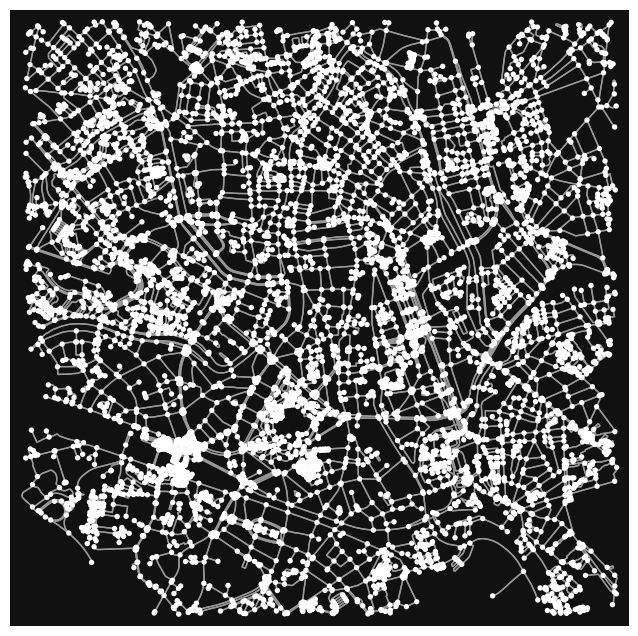

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# Define the address as a starting point
address = "Sint-kwintensberg 74, Ghent, Belgium"

# Geocode the address to get its latitude and longitude
center_point = ox.geocode(address)

# Define the buffer distance (in meters) for the map area
buffer_distance = 2000  # 2 km radius

# Download the street network data within the buffer distance around the center point
graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')

# Plot the graph to verify
ox.plot_graph(graph)

In [25]:
def calculate_route_length(graph, route):
    """Calculate the total length of a route."""
    length = 0
    for u, v in zip(route[:-1], route[1:]):
        # Extract edge data for this edge (u, v)
        edge_data = graph.get_edge_data(u, v, default={})
        # Handle cases with multiple edges
        if isinstance(edge_data, dict):
            length += edge_data.get('length', 0)
        elif isinstance(edge_data, list):
            length += min(e.get('length', float('inf')) for e in edge_data)
    return length

def simulated_annealing_with_addresses(graph, start_address, end_address, distance, max_iterations=1000, initial_temp=1000, cooling_rate=0.003):
    """
    Perform simulated annealing to find an approximate path between two addresses with a given distance constraint.

    Parameters:
    - graph: A network graph object (from OSMnx).
    - start_address: Starting address as a string.
    - end_address: Ending address as a string.
    - distance: Desired approximate distance for the route (in meters).
    - max_iterations: Maximum number of iterations (default=1000).
    - initial_temp: Starting temperature for the annealing process (default=1000).
    - cooling_rate: Cooling rate for the temperature (default=0.003).

    Returns:
    - best_route: The best route found.
    - best_length: The length of the best route.
    """
    def get_random_neighbor(route):
        """
        Generate a random neighbor by modifying the route.
        Ensures the neighbor is valid for the graph.
        """
        new_route = route[:]
        if len(route) > 2:
            idx1, idx2 = random.sample(range(1, len(route) - 1), 2)  # Avoid swapping start/end nodes
            new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
        return new_route

    # Geocode addresses to get their corresponding nodes
    start_point = ox.geocode(start_address)
    end_point = ox.geocode(end_address)
    start_node = ox.nearest_nodes(graph, start_point[1], start_point[0])
    end_node = ox.nearest_nodes(graph, end_point[1], end_point[0])

    # Initialize the route as the shortest path between start and end nodes
    current_route = nx.shortest_path(graph, start_node, end_node, weight='length')
    current_length = calculate_route_length(graph, current_route)

    best_route = current_route
    best_length = current_length
    temperature = initial_temp

    for i in range(max_iterations):
        # Generate a neighbor route
        new_route = get_random_neighbor(current_route)
        try:
            new_length = calculate_route_length(graph, new_route)
        except Exception:
            continue  # Skip invalid routes

        # Calculate penalty for deviation from target distance
        current_penalty = abs(current_length - distance)
        new_penalty = abs(new_length - distance)

        # Acceptance condition: prioritize routes closer to the target distance
        delta_penalty = new_penalty - current_penalty

        if delta_penalty < 0 or np.exp(-delta_penalty / temperature) > random.random():
            current_route = new_route
            current_length = new_length

            # Update the best route if the new one is closer to the desired distance
            if abs(current_length - distance) < abs(best_length - distance):
                best_route = current_route
                best_length = current_length

        # Cool down the temperature
        temperature *= (1 - cooling_rate)

    return best_route, best_length

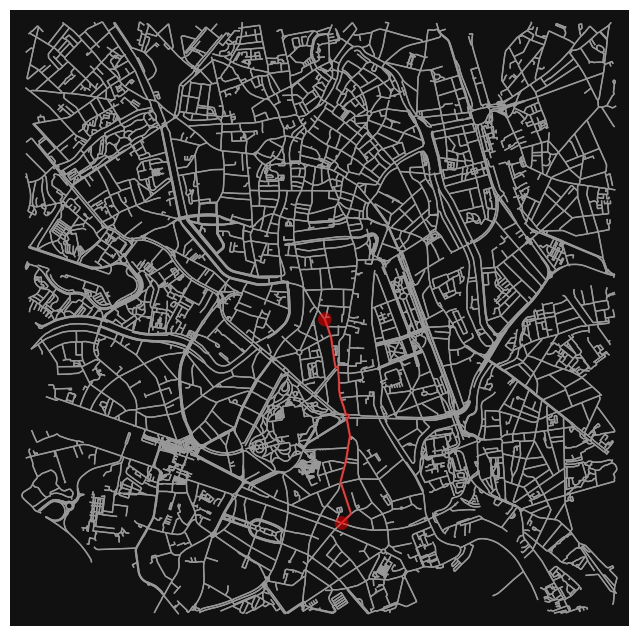

0


In [28]:
# Define the start point (latitude, longitude) and desired distance in meters
distance = 2000  # 5 kilometers

# Run the simulated annealing algorithm
best_route, best_length = simulated_annealing_with_addresses(graph, 'Sint-kwintensberg 74, Ghent, Belgium', "Burggravenlaan 327, Ghent, Belgium" , distance)

# Plot the optimized route
fig, ax = ox.plot_graph_route(graph, best_route, route_linewidth=2, node_size=0)
plt.show()
print(best_length)